<center><h1>ЛР 5 - Метод присоединённых множителей Лагранжа</h1><center>
<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1<center>
<center>Вариант №7<center>


In [1]:
import numpy as np
from numpy import array, dot
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")
plt.rc("text", usetex=True)
plt.rc("font", serif="serif")

In [2]:
def plot_contours_constrained(f, g, h, xx, yy, f_levels):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    ff = f([xx, yy])
    gg = g([xx, yy])
    hh = h([xx, yy])
    fcs = ax.contour(xx, yy, ff, f_levels, colors=sns.color_palette("ocean"))
    ax.clabel(fcs, f_levels, fmt="$f = %.2f$")
    
    for i in range(gg.shape[0]):
        gcs = ax.contour(xx, yy, gg[i], levels=[0], colors=sns.color_palette("gnuplot"), alpha=0.6)
        ax.clabel(gcs, [0], fmt="$g_{} = %.2f$".format(i+1))
    for i in range(hh.shape[0]):
        hcs = ax.contour(xx, yy, hh[i], levels=[0], colors=sns.color_palette("inferno"), alpha=0.6)
        ax.clabel(hcs, [0], fmt="$h_{} = %.2f$".format(i+1))
    
    ax.set_aspect(1)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    return fig, ax

## Постановка задачи

В этот раз мы переходим к задаче условной оптимизации - задаче, при которой множество допустимых значений переменных не совпадает с областью определения функции, а задаётся определёнными ограничениями. Ограничения бывают двух типов - ограничения типа равенства (требуют, чтобы переменные принимали значения на какой-то гиперповерхности в $\mathbb{R}^n$, формально говоря, в области, не имеющей внутренних точек) и ограничения типа неравенства (требуют, чтобы переменные принимали значения в какой-то "объёмной" области, формально говоря, имеющей внутренние точки). 

Задачу условной оптимизации обычно записывают в следующем виде:

$$
f(\mathbf{x})\to\min_{\mathbf{x}\in X}, \\ 
X\subset \mathbb{R}^n: 
    \begin{aligned} 
        g_i(\mathbf{x})\leq 0, i=\overline{1, k},\\
        h_i(\mathbf{x}) = 0, i=\overline{1, m}.
    \end{aligned}
$$

Для краткости будем иногда использовать обозначение $\mathbf{g(x)} \leq \mathbf{0}$ и $\mathbf{h(x)} = \mathbf{0}$, полагая, что $\mathbf{g}: \mathbb{R}^n \to \mathbb{R}^k$, $\mathbf{g(x)}=\left[ g_1(\mathbf{x}) \dots g_k(\mathbf{x}) \right]^T$ и 
$\mathbf{h}: \mathbb{R}^n \to \mathbb{R}^m$, $\mathbf{h(x)}=\left[ h_1(\mathbf{x}) \dots h_m(\mathbf{x}) \right]^T$.

Будем работать со следующим примером:
$$
f(\mathbf{x})\equiv -6x_1 - 4x_2 + x_1^2 + \frac{1}{2}x_2^2 + x_1 x_2 \to\min_{\mathbf{x}\in X}, \\ 
X: 
    \begin{aligned} 
        x_1^2 + x_2^2 - 4 \leq 0,\\
        x_1 \leq 0, x_2 \leq 0,\\
        2x_1 - x_2 = 0.
    \end{aligned}
$$

Сама функция и её градиент:

In [3]:
def f(x):
    return -6*x[0] - 4*x[1] + x[0]**2 + .5*x[1]**2 + x[0]*x[1]

def jacf(x):
    return array([2*x[0] + x[1] - 6, x[0] + x[1] - 4])

Вектор ограничений-неравенств $\mathbf{g(x)}$ и его матрица Якоби:

In [4]:
def g(x):
    return array([
        x[0]**2 + x[1]**2 - 4,
        -x[0],
        -x[1]
    ])

def jacg(x):
    return array([
        [2*x[0], 2*x[1]], 
        [    -1,      0], 
        [     0,     -1]
    ])

Вектор ограничений-равенств $\mathbf{h(x)}$ и его матрица Якоби:

In [5]:
def h(x):
    return array([2*x[0] - x[1]])

def jach(x):
    return array([[2, -1]])

График линий уровня целевой функции с нанесенными ограничениями:

<IPython.core.display.Javascript object>


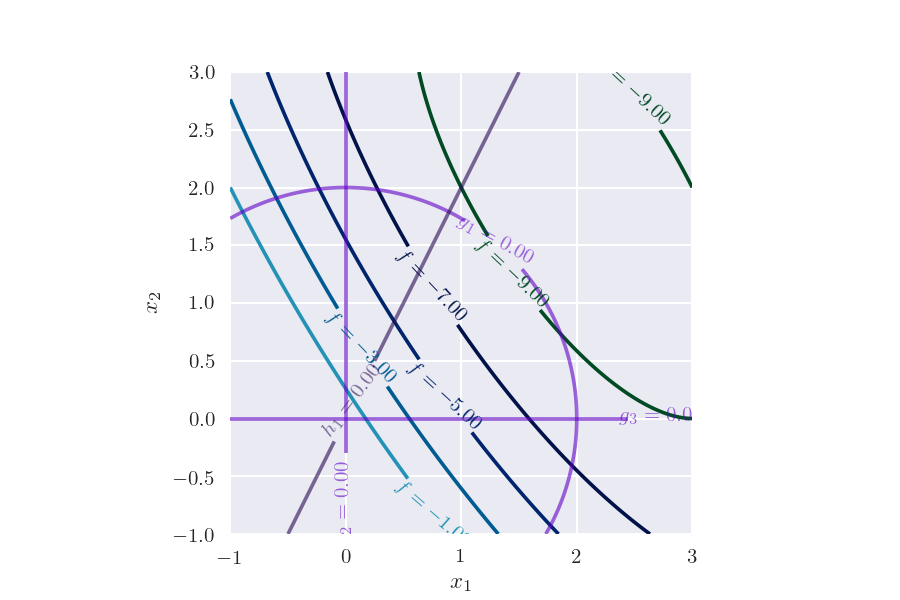

In [6]:
delta = 0.01
x1 = np.arange(-1, 3+delta, delta)
x2 = np.arange(-1, 3+delta, delta)
xx1, xx2 = np.meshgrid(x1, x2)

plot_contours_constrained(f, g, h, xx1, xx2, f_levels=[-9, -7, -5, -3, -1]);

Фактически, мы хотим найти наименьшее значение функции на той части прямой $2x_1 = x_2$, что лежит внутри полукруга. Визуально легко увидеть, что минимум будет как раз в точке пересечения этой линии и графика окружности
в точке $\mathbf{x}^{*}=\left[\frac{2\sqrt{5}}{5} , \frac{4\sqrt{5}}{5}\right]^T$. 

Рассмотрим теперь один из методов, позволяющих получить этот результат численно.

## Метод присоединённых множителей Лагранжа

In [7]:
# Lagrange function
def lagrange(f, g, h, lbda, mu, c):
    return lambda x: (f(x) 
                      + dot(lbda, h(x)) + c/2*dot(h(x), h(x)) 
                      + 0.5/c*np.sum( np.maximum(0, mu+c*g(x))**2 - mu**2 ))

# Its derivative (for faster inner unconstrained optimization)
def lagrange_jac(f, g, h, jacf, jacg, jach, lbda, mu, c):
    return lambda x: (jacf(x) 
                      + dot(jach(x).T, lbda+c*h(x))
                      + dot(jacg(x).T, np.maximum(mu+c*g(x), 0)))

In [8]:
def fmin_augmented_lagrangian(f, g, h, x0, jacf, jacg, jach, eps=0.001):
    
    # problem dimensionality
    n, m, k = len(x0), len(g(x0)), len(h(x0))
    X = [x0]
    
    # initial values of Lagrange multipliers
    lbda, mu = np.ones(k), np.ones(m)
    # and hyperparameters
    c = 0.1
    
    while True:
        # create Lagrangian function and its derivative
        # given current values of Lagrangian multipliers
        L = lagrange(f, g, h, lbda, mu, c)
        jacL = lagrange_jac(f, g, h, jacf, jacg, jach, lbda, mu, c)
        
        # perform unconstrained optimization of Lagrangian
        res = minimize(L, X[-1], method='BFGS', jac=jacL, tol=0.1*eps)
        X.append(res.x)
        
        # update Lagrangian multipliers
        lbda += c*h(X[-1])
        mu = np.maximum(0, mu + c*g(X[-1]))
        c *= 8
        
        # check for breaking conditions
        if np.linalg.norm(X[-1] - X[-2]) < eps:
            break
        
    return OptimizeResult(x=X[-1], fun=f(X[-1]),
                          x_hist=np.c_[X].T, 
                          f_hist=f(np.c_[X].T), 
                          nit=len(X)-1)

В качетсве начальной точки возьмём точку $(2; 2)$ - точку глобального безусловного минимума функции $f$.

In [9]:
x0 = array([2, 2])

In [10]:
res = fmin_augmented_lagrangian(f, g, h, x0, jacf, jacg, jach, 0.001)
x1_hist, x2_hist = res.x_hist
print("Approximate solition with ALM method: (%.6f, %.6f).\n" % (res.x[0], res.x[1]),
      "Function value in this point: %.6f.\n" % res.fun, sep="")

print("Exact solition: (%.6f, %.6f).\n" % (0.4*np.sqrt(5), 0.8*np.sqrt(5)),
      "Function value in this point: %.6f.\n" % f([0.4*np.sqrt(5), 0.8*np.sqrt(5)]), sep="")

print("Number of iterations of Augmented Lagrangian Multipliers: %d." % res.nit)
print("Time of execution:")
%timeit fmin_augmented_lagrangian(f, g, h, x0, jacf, jacg, jach, 0.001)

Approximate solition with ALM method: (0.894427, 1.788854).
Function value in this point: -8.521980.

Exact solition: (0.894427, 1.788854).
Function value in this point: -8.521981.

Number of iterations of Augmented Lagrangian Multipliers: 5.
Time of execution:
8.22 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Видим, что метод за довольно небольшое количество итераций и затраченное время (соизмериемое с тем, что мы получали для задач безусловной оптимизации) сошёлся к точному решению (с допустимой точностью).

На графике ниже красным цветом выделена траектория минимизирующей последовательности.

<IPython.core.display.Javascript object>


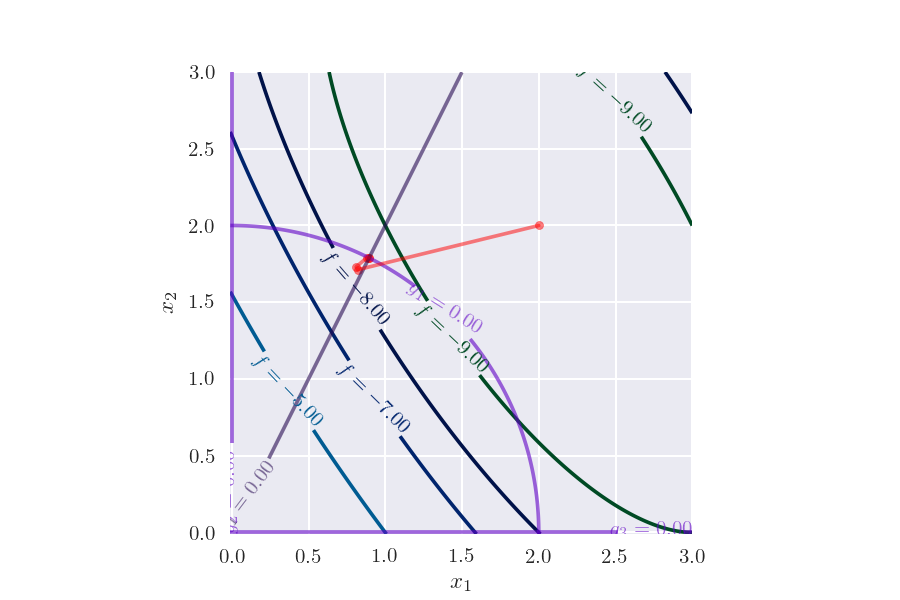

In [11]:
delta = 0.01
x1 = np.arange(-delta, 3+delta, delta)
x2 = np.arange(-delta, 3+delta, delta)
xx1, xx2 = np.meshgrid(x1, x2)

fig, ax = plot_contours_constrained(f, g, h, xx1, xx2, f_levels=[-9, -8, -7, -5])
ax.plot(res.x_hist[0], res.x_hist[1], color='r', alpha=0.5);
ax.scatter(res.x_hist[0], res.x_hist[1], s=15, c='r', alpha=0.5);